<a href="https://colab.research.google.com/github/Mabalzich/MLFinalProject/blob/main/ECE4424FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# imported libraries
# a lot are similar to homework 4
from tensorflow import keras
from keras import optimizers
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras import backend as K
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from scipy.spatial.distance import cdist

In [26]:
# parameters for this script
batch_size = 32
num_classes = 10
epochs = 100
learningrate = 0.0001

In [27]:
#recall function from keras documentation
def recallscore(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [28]:
#precision function from keras documentation
def precisionscore(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [29]:
#f1 score from keras documentation
def f1score(y_true, y_pred):
    precision = precisionscore(y_true, y_pred)
    recall = recallscore(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
def generate_data():
  # Load and read splited training and test data set
  (x_train, y_train), (x_test, y_test) = mnist.load_data()  
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')

  # Convert class vectors to binary class matrices.
  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)
  # normalize the data
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  # partition training set into training and validation set
  x_validate = x_train[50000:,:]
  x_train = x_train[:50000,:]
  y_validate = y_train[50000:,:]
  y_train = y_train[:50000,:]

  return x_train, y_train, x_validate, y_validate, x_test, y_test

In [31]:
x_train, y_train, x_validate, y_validate, x_test, y_test = generate_data()

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [32]:
def base_cnn():
  model = Sequential()

  model.add(Conv1D(28, 3, padding='same',input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv1D(28, 3, padding='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling1D(pool_size=2))

  model.add(Dropout(0.25))
 
  model.add(Conv1D(56, 3, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(56, 3, padding='same'))
  model.add(Activation('relu'))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(learning_rate=learningrate, decay=1e-6)

  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy', f1score, precisionscore, recallscore])
  print(model.summary())

  return model

In [33]:
class GraphNet(nn.Module):
    def __init__(self, image_size = 28):
        super(GraphNet, self).__init__()
        N = image_size ** 2 # Number of pixels in the image
        self.fc = nn.Linear(N, 10, bias = False)
        # Create the adjacency matrix of size (N X N)
        # Use a pre-computed adjacency matrix
        A = self.precompute_adjacency_images(image_size)
        self.register_buffer('A', A) # not to be considered a model paramater that is updated during training

    def forward(self, x):
        '''
        x: image (batch_size x 1 x image_width x image_height)
        '''
        B = x.size(0) # 64
        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1), 
                                            x.view(B, -1, 1)).view(B, -1)) # (64 X 784)
        return self.fc(avg_neighbor_features)

    @staticmethod
    # Static method knows nothing about the class and just deals with the parameters.
    def precompute_adjacency_images(image_size):
        print('precompute_adjacency_images')
        col, row = np.meshgrid(np.arange(image_size), np.arange(image_size)) # (28 x 28) Explanation: https://www.geeksforgeeks.org/numpy-meshgrid-function/
        coord = np.stack((col, row), axis = 2).reshape(-1, 2) / image_size # (784 x 2) --> normalize
        dist = cdist(coord, coord) # compute distance between every pair of pixels
        sigma = 0.05 * np.pi # width of the Gaussian (can be a hyperparameter while training a model)
        A = np.exp(-dist / sigma ** 2) # adjacency matrix of spatial similarity
        A[A < 0.01] = 0 # suppress values less than 0.01
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        print(A_hat[:10, :10])
        return A_hat

In [34]:
def train(model, train_loader, optimizer, epoch):
    accuracy = []
    f1score = []
    precision = []
    recall = []
    p_inter = [[0,0] for x in range(10)]
    r_inter = [[0,0] for x in range(10)]
    correct = 0
    total = 0
    next = 1
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        # Cross entropy loss
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        for p, t, c in zip(pred,target,pred.eq(target.view_as(pred))):
          p_inter[p.item()][0] += c.item()
          p_inter[p.item()][1] += 1
          r_inter[p.item()][0] += c.item()
          r_inter[t.item()][1] += 1
        total += len(data)
        if total > (next * 10000):
          next += 1
          #macro averaging
          prec = sum([1.0 * x[0]/x[1] for x in p_inter]) / 10.0
          rec = sum([1.0 * x[0]/x[1] for x in r_inter]) / 10.0
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: ({:.2f}%) F1 Score: ({:.2f}%) Precision: ({:.2f}%) Recall: ({:.2f}%)'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(),
              100. * correct / total, 100. * 2*((prec*rec)/(prec+rec+1e-12)), 100. * prec, 100. * rec))
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: ({:.2f}%) F1 Score: ({:.2f}%) Precision: ({:.2f}%) Recall: ({:.2f}%)'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(),
              100. * correct / total, 100. * 2*((prec*rec)/(prec+rec+1e-12)), 100. * prec, 100. * rec))
    prec = sum([1.0 * x[0]/x[1] for x in p_inter]) / 10.0
    rec = sum([1.0 * x[0]/x[1] for x in r_inter]) / 10.0
    return 1.0 * correct / total, 2*((prec*rec)/(prec+rec+1e-12)), prec, rec

In [35]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return 1. * correct / len(test_loader.dataset)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 28, 28)            2380      
                                                                 
 activation_12 (Activation)  (None, 28, 28)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 28, 28)            2380      
                                                                 
 activation_13 (Activation)  (None, 28, 28)            0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 14, 28)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 28)            0         
                                                      

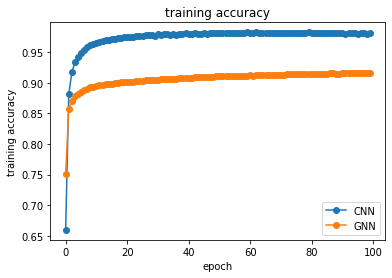

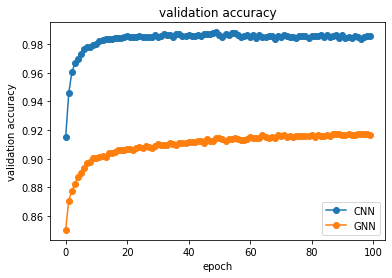

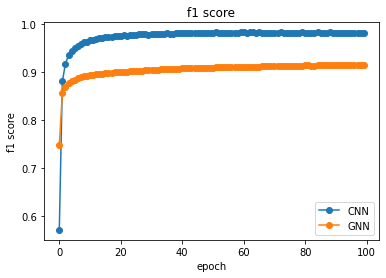

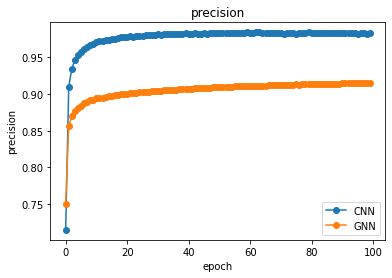

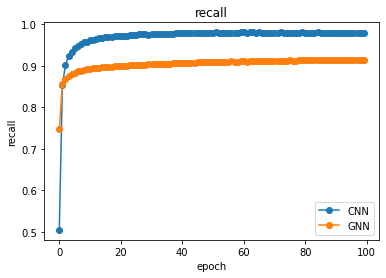

In [36]:
model =  base_cnn()
fit = model.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_data=(x_validate, y_validate),
                                shuffle=True)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=False)    

model = GraphNet()

optimizer = optim.SGD(model.parameters(), lr = learningrate, weight_decay = 1e-4)

print('number of trainable parameters: %d' %
      np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

accuracy = []
f1scores = []
precision = []
recall = []
val_accuracy = []
for epoch in range(1, epochs + 1):
  acc, f1, prec, rec = train(model, train_loader, optimizer, epoch)
  accuracy.append(acc)
  f1scores.append(f1)
  precision.append(prec)
  recall.append(rec)
  val_accuracy.append(test(model, test_loader))

# Plot training accuracy
plt.plot(fit.history['accuracy'], 'o-', label='CNN')
plt.plot([item for item in accuracy if item is not None], 'o-', label='GNN')

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot validation accuracy
plt.plot(fit.history['val_accuracy'], 'o-', label='CNN')
plt.plot([item for item in val_accuracy if item is not None], 'o-', label='GNN')

plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot f1 score
plt.plot(fit.history['f1score'], 'o-', label='CNN')
plt.plot([item for item in f1scores if item is not None], 'o-', label='GNN')

plt.title('f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot precision
plt.plot(fit.history['precisionscore'], 'o-', label='CNN')
plt.plot([item for item in precision if item is not None], 'o-', label='GNN')

plt.title('precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot recall
plt.plot(fit.history['recallscore'], 'o-', label='CNN')
plt.plot([item for item in recall if item is not None], 'o-', label='GNN')

plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()